 To run this colab, press the "Rutime" button in the menu tab and then press the "Run all" button.

# Problem Statement: To identify whether the Mangoes are Alphonso or not.

# Transfer learning with a pretrained ConvNet

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.



 The Notebook  workflow :
 1. Data Collection: Webscrapping via Google images.

2.Examine and understand the data

3.Build an input pipeline, in this case using Keras ImageDataGenerator

4.Compose the model
-Load in the pretrained base model (and pretrained weights)

-Stack the classification layers on top

5.Train the model

6.Evaluate model

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


##!pip install tensorflow-gpu==1.15
#!pip install tensorflow-hub>=0.3
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
tf.__version__
!pip install keras==2.3.1

Uplaod the Dataset

In [0]:
base_dir = "/content/drive/My Drive/Mango"


Use ImageDataGenerator to rescale the images.

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',    
    subset='validation')

Found 440 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


Checking the Shapes of the DataSet

In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 2))

Save the labels in a file which will be downloaded later.

In [0]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Alphonso': 0, 'Non-Alphonso': 1}


In [0]:
!cat labels.txt

Alphonso
Non-Alphonso

Create the base model from the pre-trained convnets
Create the base model from the MobileNet V2 model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False

## Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(16, 3,padding='same', activation='relu',input_shape=IMG_SHAPE),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Dense(2, activation='softmax')
])  

## Compile the model
You must compile the model before training it. Since there are two classes, use a binary cross-entropy loss.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 16)          184336    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          1

In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 10


## Train the model

In [0]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [0]:
initial_epochs = 20

history = model.fit_generator(train_generator, 
                    epochs=initial_epochs, 
                    validation_data=val_generator,
                    steps_per_epoch=10,
                    validation_steps=64//64)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
10/10 [==============================] - 196s 20s/step - loss: 0.6480 - accuracy: 0.5938 - val_loss: 0.5494 - val_accuracy: 0.6875
Epoch 2/20
10/10 [==============================] - 77s 8s/step - loss: 0.4286 - accuracy: 0.8045 - val_loss: 0.4906 - val_accuracy: 0.8125
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 0.4559 - accuracy: 0.7917 - val_loss: 0.3141 - val_accuracy: 0.9062
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.8622

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 9s 882ms/step - loss: 0.3274 - accuracy: 0.8622 - val_loss: 0.2737 - val_accuracy: 0.8750
Epoch 5/20
10/10 [==============================] - 8s 806ms/step - loss: 0.2572 - accuracy: 0.8910 - val_loss: 0.4034 - val_accuracy: 0.8125
Epoch 6/20
10/10 [==============================] - 7s 688ms/step - loss: 0.2748 - accuracy: 0.9062 - val_loss: 0.2642 - val_accuracy: 0.9062
Epoch 7/20
10/10 [==============================] - 7s 691ms/step - loss: 0.2541 - accuracy: 0.9156 - val_loss: 0.4376 - val_accuracy: 0.8125
Epoch 8/20
10/10 [==============================] - 8s 758ms/step - loss: 0.2921 - accuracy: 0.8844 - val_loss: 0.3494 - val_accuracy: 0.9062
Epoch 9/20
10/10 [==============================] - 7s 659ms/step - loss: 0.1995 - accuracy: 0.9187 - val_loss: 0.4069 - val_accuracy: 0.8750
Epoch 10/20
10/10 [==============================] - 7s 673ms/step - loss: 0.1756 - accuracy: 0.9281 - val_loss: 0.1602 - val_accuracy: 0.9062
Epoch 11/20
10/1

## Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

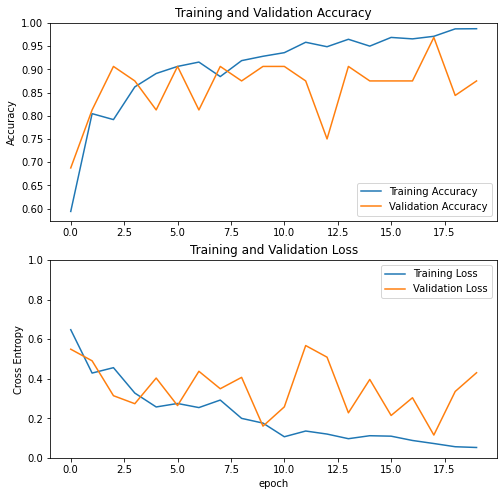

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

# Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


## Compile the model
Compile the model using a much lower training rate.

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 16)          184336    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          1

In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 66


## Continue Train the model

In [0]:
fine_tune_epochs =20
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit_generator(train_generator, 
                    epochs=total_epochs,
                    initial_epoch =  history.epoch[-1], 
                    validation_data=val_generator,
                    steps_per_epoch=10)

Epoch 20/40
10/10 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.7724

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 9s 880ms/step - loss: 0.8507 - accuracy: 0.7724 - val_loss: 0.4464 - val_accuracy: 0.8519
Epoch 21/40
10/10 [==============================] - 8s 814ms/step - loss: 0.7071 - accuracy: 0.7781 - val_loss: 0.3930 - val_accuracy: 0.8796
Epoch 22/40
10/10 [==============================] - 8s 807ms/step - loss: 0.5764 - accuracy: 0.8045 - val_loss: 0.3373 - val_accuracy: 0.9352
Epoch 23/40
10/10 [==============================] - 8s 813ms/step - loss: 0.5961 - accuracy: 0.8141 - val_loss: 0.4378 - val_accuracy: 0.8889
Epoch 24/40
10/10 [==============================] - 8s 781ms/step - loss: 0.3831 - accuracy: 0.8494 - val_loss: 0.4006 - val_accuracy: 0.9074
Epoch 25/40
10/10 [==============================] - 8s 783ms/step - loss: 0.3561 - accuracy: 0.8781 - val_loss: 0.4038 - val_accuracy: 0.8889
Epoch 26/40
10/10 [==============================] - 8s 811ms/step - loss: 0.3585 - accuracy: 0.8718 - val_loss: 0.4041 - val_accuracy: 0.8981
Epoch 27/40

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

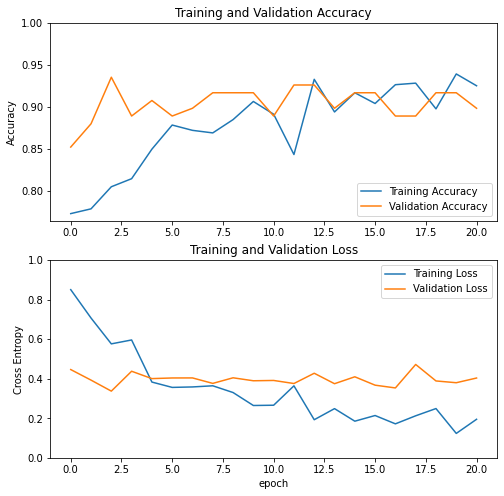

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite
Saved the model using tf.saved_model.save and then convert the saved model to a tf lite compatible format.

In [0]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()



with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


Download the converted model and labels

In [0]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')